# <center>**Sentiment analysis for marketing** </center>

In the development of a sentiment analysis project focused on evaluating sentiments towards US airlines, this phase has been focussed in applying natural language processing (NLP) techniques to prepare and preprocess the textual data. The data has undergone thorough cleaning and transformation, setting the stage for effective sentiment analysis. Three distinct machine learning classification models, namely Decision Tree, AdaBoost, and XGBoost, have been employed to train and test sentiment prediction. These models bring diverse approaches and strengths to the task, allowing for a comprehensive exploration of sentiment trends and providing valuable insights into passengers' opinions regarding US airlines.

# Importing the dependencies

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading the data

In [2]:
df= pd.read_csv("/kaggle/input/twitter-airline-sentiment/Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Data preprocessing and EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
df.shape

(14640, 15)

In [5]:
missing_values = df.isnull().sum()

In [6]:
missing_values

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [7]:
columns_to_drop = ['tweet_coord', 'airline_sentiment_gold', 'negativereason_gold']
df = df.drop(columns=columns_to_drop)


In [8]:
def plotBars(col):
    sns.countplot(x=col, hue=col, data=df ,palette="ch:.25")

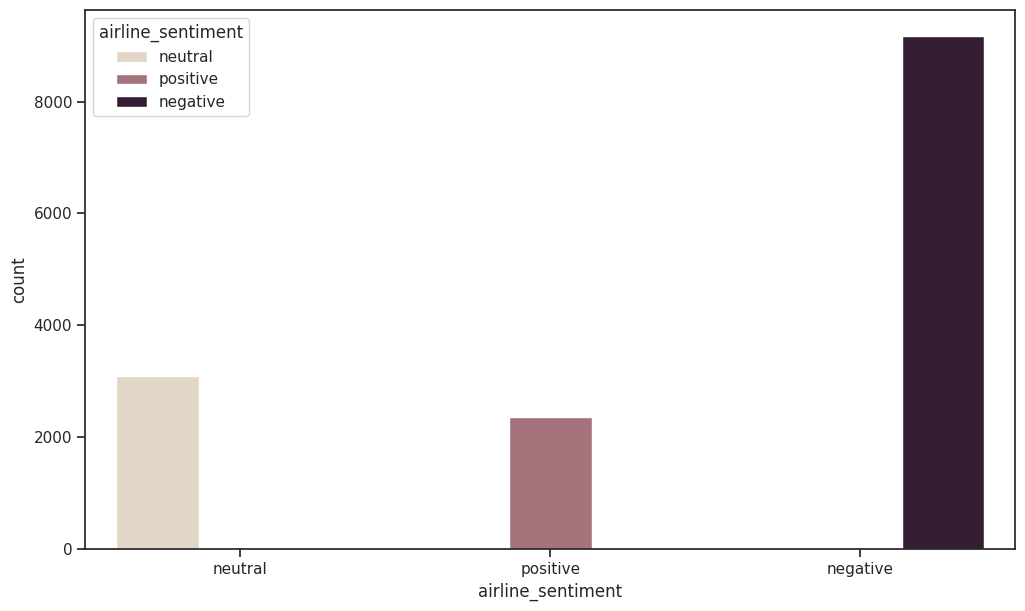

In [9]:
plt.figure(figsize=(12,7))
plotBars('airline_sentiment')

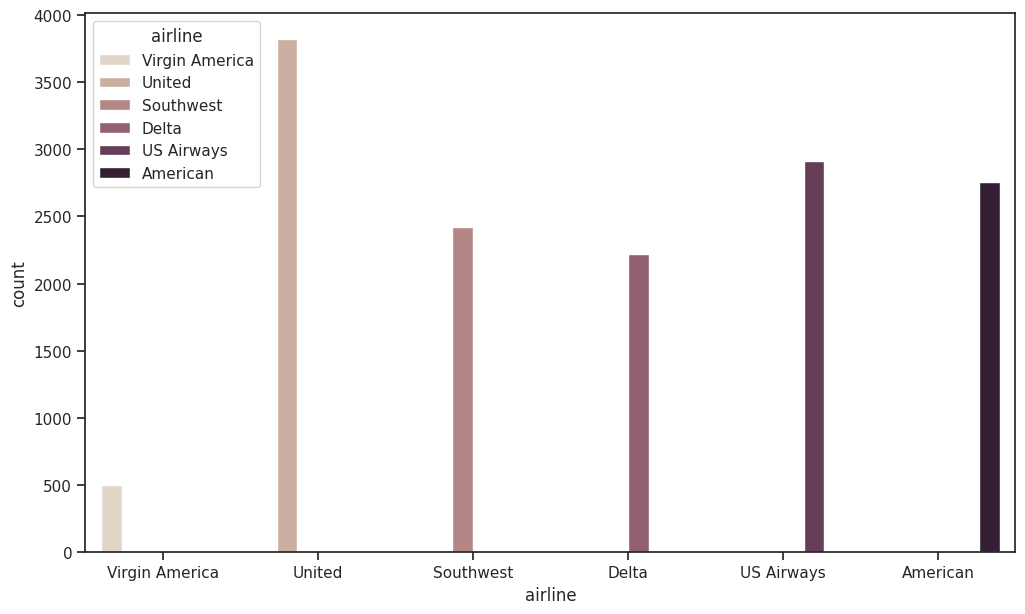

In [10]:
plt.figure(figsize=(12,7))
plotBars('airline')

In [11]:
def NRC(Airline):
    if Airline=='All':
        dfs=df
    else:
        dfs=df[df['airline']==Airline]
    count=dict(df['negativereason'].value_counts())
    Unq_re=list(df['negativereason'].unique())
    Unq_re=[x for x in Unq_re if str(x) != 'nan']
    reason=pd.DataFrame({'Reasons':Unq_re})
    reason['count']=reason['Reasons'].apply(lambda x: count[x])
    return reason
NRC('All')

,Reasons,count
0,Bad Flight,580
1,Can't Tell,1190
2,Late Flight,1665
3,Customer Service Issue,2910
4,Flight Booking Problems,529
5,Lost Luggage,724
6,Flight Attendant Complaints,481
7,Cancelled Flight,847
8,Damaged Luggage,74
9,longlines,178


In our analysis, we visually highlight the primary factors contributing to negative sentiments, and it becomes evident that customer service, flight process issues, delays, and poor leadership are the predominant concerns. We can distill the core issue into the key to success: customer service. This is underscored by instances where tweets mention problems, often accompanied by complaints about subpar customer service.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


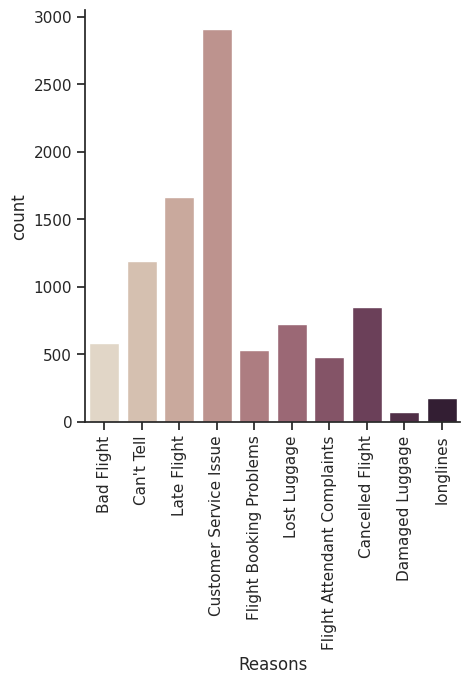

In [12]:
g = sns.catplot(x="Reasons", y="count", palette="ch:.25" ,kind="bar",data=NRC('All'))
g.set_xticklabels(rotation=90)

**Creating word cloud for visualizing positive and negative words mentioned in these tweets**

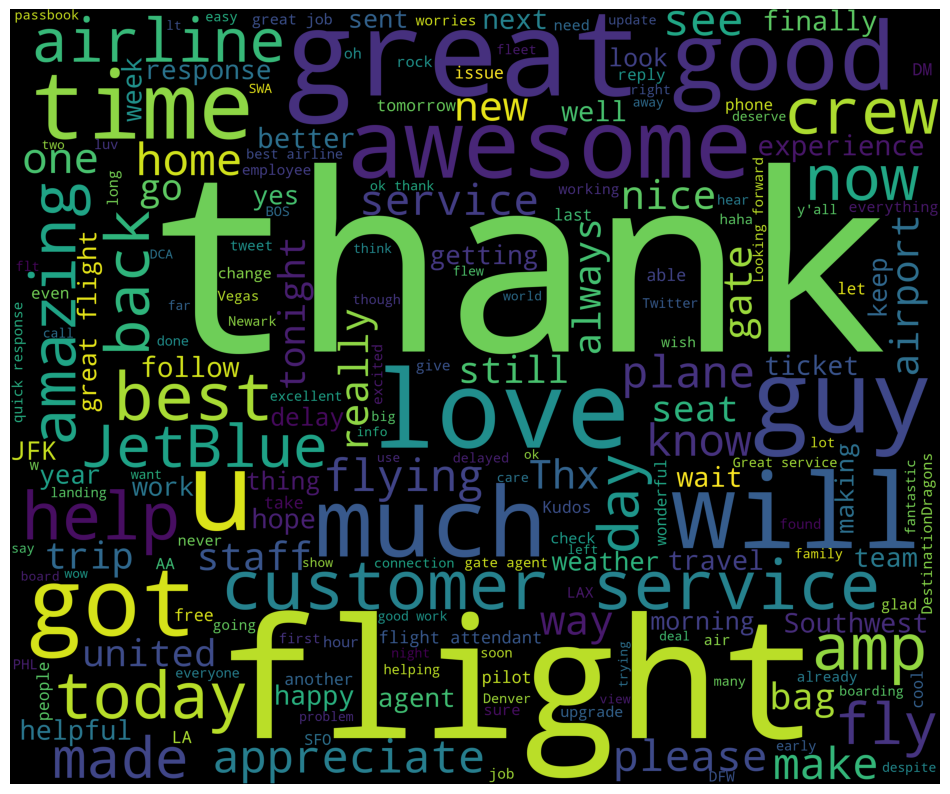

In [13]:
dfs=df[df['airline_sentiment']=='positive']
words = ' '.join(dfs['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

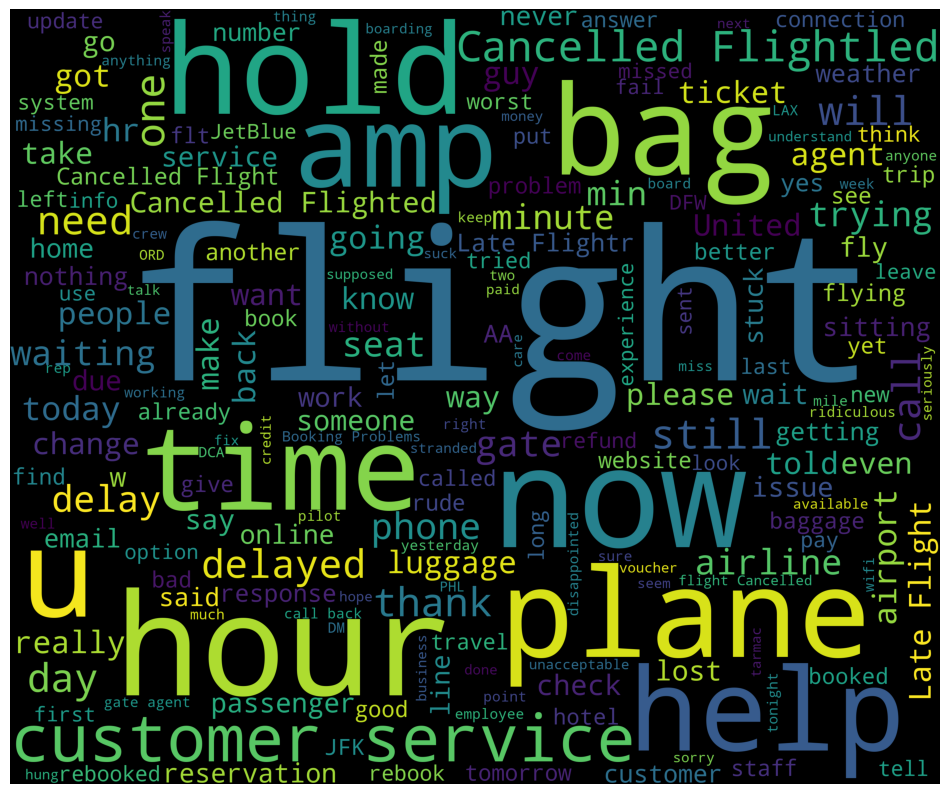

In [14]:
dfs=df[df['airline_sentiment']=='negative']
words = ' '.join(dfs['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# NLP Preprocessing

**Create a function that transforms tweets into individual words, but only if the words are not part of the stopword list.**

In the realm of natural language processing, we designate certain words as "stop words" because they are considered uninformative in textual data. Stop words include commonly used words like "the," "a," "an," and "in." Search engines are programmed to disregard these stop words when indexing content for searches and when presenting search results in response to user queries.

In [15]:
def Words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

**Here we trying to make it cleanTweet and That's mean we need it to be just in english language**

In [16]:
def clean_tweet_length(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words)) 

In this stage, we begin processing data with a numeric approach, bridging the gap between the negative and positive sentiments. This transformation is essential because our machine lacks the ability to handle textual data; it operates solely with numerical representations, each corresponding to distinct classes.

In [17]:
df['sentiment']=df['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)
df['clean_tweet']=df['text'].apply(lambda x: Words(x))
df['Tweet_length']=df['text'].apply(lambda x: clean_tweet_length(x))

# Train test Split

In [18]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

Applying the clean_tweet function we created earlier

In [19]:
train_clean_tweet=[]
for i in train['clean_tweet']:
    train_clean_tweet.append(i)
test_clean_tweet=[]
for j in test['clean_tweet']:
    test_clean_tweet.append(j)

The data is already clean, but now we need to transform it into a "word-level vectorization." This process involves converting a set of text documents into a matrix that counts the occurrence of individual words. While performing this transformation, we will retain the preprocessing and n-gram generation steps while replacing the string tokenization process.

In [20]:
vect = CountVectorizer(analyzer = "word")
train_features= vect.fit_transform(train_clean_tweet)
test_features=vect.transform(test_clean_tweet)

# Model Building

In [21]:
Classifier= [DecisionTreeClassifier(),RandomForestClassifier(n_estimators=250),AdaBoostClassifier(),XGBClassifier(n_estimators=250)]

In [22]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]

In [23]:
for classifier in Classifier:
    try:
        fit = classifier.fit(train_features, train['sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train['sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred, test['sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy))

Accuracy of DecisionTreeClassifier is 0.7640027322404371
Accuracy of RandomForestClassifier is 0.8131830601092896
Accuracy of AdaBoostClassifier is 0.7855191256830601
Accuracy of XGBClassifier is 0.8275273224043715
